## Customer Churn Prediction — Model Training & Evaluation

### Import dependencies

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Load Processed Data

In [27]:
# # Load cleaned data
path_cleaned = "../data/processed/churn_cleaned.csv"
df = pd.read_csv(path_cleaned)

# Display the dataset
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,MonthlyCharges,TotalCharges,Churn,InternetService_Fiber optic,InternetService_No,Contract_2-Year,Contract_Monthly,PaymentMethod_Card Auto,PaymentMethod_E-Check,PaymentMethod_Mail
0,0,0,1,0,-1.277445,0,0,0,1,0,...,-1.160323,-0.994242,0,0,0,0,1,0,1,0
1,1,0,0,0,0.066327,1,0,1,0,1,...,-0.259629,-0.173244,0,0,0,0,0,0,0,1
2,1,0,0,0,-1.236724,1,0,1,1,0,...,-0.362660,-0.959674,1,0,0,0,1,0,0,1
3,1,0,0,0,0.514251,0,0,1,0,1,...,-0.746535,-0.194766,0,0,0,0,0,0,0,0
4,0,0,0,0,-1.236724,1,0,0,0,0,...,0.197365,-0.940470,1,1,0,0,1,0,1,0


#### Train-test Split

In [28]:
# Separate input features and target
X = df.drop("Churn", axis=1)
y = df["Churn"]

In [29]:
X.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,PaperlessBilling,MonthlyCharges,TotalCharges,InternetService_Fiber optic,InternetService_No,Contract_2-Year,Contract_Monthly,PaymentMethod_Card Auto,PaymentMethod_E-Check,PaymentMethod_Mail
0,0,0,1,0,-1.277445,0,0,0,1,0,...,1,-1.160323,-0.994242,0,0,0,1,0,1,0
1,1,0,0,0,0.066327,1,0,1,0,1,...,0,-0.259629,-0.173244,0,0,0,0,0,0,1
2,1,0,0,0,-1.236724,1,0,1,1,0,...,1,-0.362660,-0.959674,0,0,0,1,0,0,1
3,1,0,0,0,0.514251,0,0,1,0,1,...,0,-0.746535,-0.194766,0,0,0,0,0,0,0
4,0,0,0,0,-1.236724,1,0,0,0,0,...,1,0.197365,-0.940470,1,0,0,1,0,1,0


In [30]:
y.head()

0    0
1    0
2    1
3    0
4    1
Name: Churn, dtype: int64

In [31]:
# Stratified split to maintain class distribution
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)        #stratify=y preserves the class ratio

In [32]:
print('X_train:',X_train.shape, '\nX test:',X_test.shape)

X_train: (5634, 23) 
X test: (1409, 23)


#### Train Baseline Models (Random Forest & XGBoost)

In [33]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

In [34]:
# Random Forest baseline
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
print("Random Forest:")
print(classification_report(y_test, rf.predict(X_test)))

# XGBoost baseline
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb.fit(X_train, y_train)
print("XGBoost:")
print(classification_report(y_test, xgb.predict(X_test)))

Random Forest:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1035
           1       0.63      0.49      0.55       374

    accuracy                           0.79      1409
   macro avg       0.73      0.69      0.71      1409
weighted avg       0.78      0.79      0.78      1409

XGBoost:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1035
           1       0.61      0.53      0.57       374

    accuracy                           0.79      1409
   macro avg       0.73      0.71      0.71      1409
weighted avg       0.78      0.79      0.78      1409



d:\Projects\customer-churn-prediction\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [00:57:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


#### Model Selection Strategy

#### Model Tuning: Handle Class Imbalance & Tune XGBoost

In [35]:
from sklearn.model_selection import RandomizedSearchCV

# Compute scale_pos_weight
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

# Parameter grid
param_dist = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.8, 1],
    "colsample_bytree": [0.8, 1],
    "scale_pos_weight": [scale_pos_weight]
}

In [36]:
# RandomizedSearchCV
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_dist,
    n_iter=10,
    scoring="f1",
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)
search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


d:\Projects\customer-churn-prediction\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [01:00:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,estimator,"XGBClassifier...ree=None, ...)"
,param_distributions,"{'colsample_bytree': [0.8, 1], 'learning_rate': [0.01, 0.1, ...], 'max_depth': [3, 5, ...], 'n_estimators': [100, 200, ...], ...}"
,n_iter,10
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


#### Evaluate Tuned Model

In [37]:
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)

print("Best Parameters:", search.best_params_)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


Best Parameters: {'subsample': 0.8, 'scale_pos_weight': np.float64(2.768561872909699), 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
[[761 274]
 [ 72 302]]
              precision    recall  f1-score   support

           0       0.91      0.74      0.81      1035
           1       0.52      0.81      0.64       374

    accuracy                           0.75      1409
   macro avg       0.72      0.77      0.73      1409
weighted avg       0.81      0.75      0.77      1409



#### Feature Importance

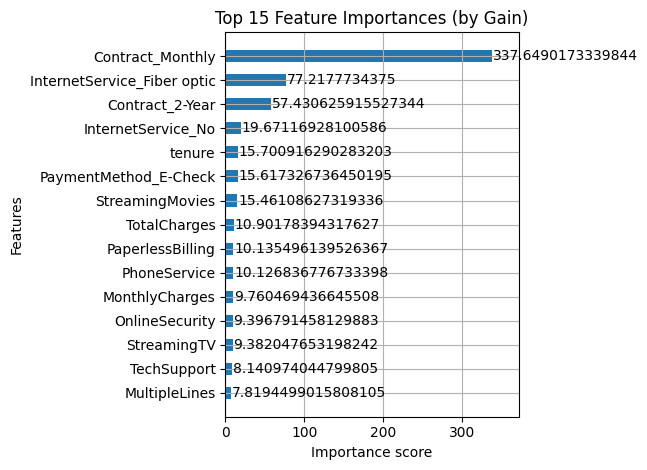

In [ ]:
import matplotlib.pyplot as plt
import xgboost as xgb

xgb.plot_importance(best_model, max_num_features=15, importance_type='gain', height=0.5)
plt.title("Top 15 Feature Importances (by Gain)")
plt.tight_layout()
plt.show()

#### Save Model

In [42]:
import joblib

joblib.dump(best_model, "../models/xgb_churn_model.pkl")

['../models/xgb_churn_model.pkl']

In [48]:
model = joblib.load("../models/xgb_churn_model.pkl")
df = pd.read_csv("../data/processed/churn_cleaned.csv")

df_copy= df.copy()

X = df.drop("Churn", axis=1)
y = df["Churn"]

predictions = model.predict(X)
df_copy["PredictedChurn"] = predictions


In [49]:
df_copy.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,TotalCharges,Churn,InternetService_Fiber optic,InternetService_No,Contract_2-Year,Contract_Monthly,PaymentMethod_Card Auto,PaymentMethod_E-Check,PaymentMethod_Mail,PredictedChurn
0,0,0,1,0,-1.277445,0,0,0,1,0,...,-0.994242,0,0,0,0,1,0,1,0,1
1,1,0,0,0,0.066327,1,0,1,0,1,...,-0.173244,0,0,0,0,0,0,0,1,0
2,1,0,0,0,-1.236724,1,0,1,1,0,...,-0.959674,1,0,0,0,1,0,0,1,1
3,1,0,0,0,0.514251,0,0,1,0,1,...,-0.194766,0,0,0,0,0,0,0,0,0
4,0,0,0,0,-1.236724,1,0,0,0,0,...,-0.940470,1,1,0,0,1,0,1,0,1


## Summary

- Trained and compared two models: Random Forest and XGBoost  
- Chose XGBoost for its higher recall on churners  
- Tuned it using RandomizedSearchCV with class weight  
- Achieved improved recall and F1-score  
- Saved the trained model for deployment